In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

import pandas as pd

In [6]:
path = "measurements/"

df_pvals = pd.read_csv(path + "logit_1_p_values.csv")

df = pd.read_parquet(path + "layer_1.parquet")
df.head()

,layer,logit_0,logit_1,logit_2,logit_3,logit_4,logit_5,logit_6,logit_7,logit_8,...,logit_118,logit_119,logit_120,logit_121,logit_122,logit_123,logit_124,logit_125,logit_126,logit_127
0,1,-3.390625,-5.34375,-4.062500,-5.250000,-5.59375,-5.125000,-5.06250,-5.03125,-4.71875,...,-5.68750,-5.906250,-6.18750,-6.09375,-4.21875,-4.656250,-5.87500,-4.96875,-6.31250,-5.812500
1,1,-5.156250,-3.75000,-3.000000,-3.531250,-4.62500,-4.156250,-4.56250,-4.78125,-3.40625,...,-4.37500,-4.750000,-4.56250,-4.53125,-3.21875,-3.890625,-4.28125,-4.50000,-4.62500,-4.500000
2,1,-5.687500,-5.03125,-5.218750,-5.281250,-5.00000,-4.250000,-5.18750,-4.59375,-4.25000,...,-5.50000,-5.250000,-6.31250,-5.84375,-3.81250,-4.187500,-3.59375,-5.78125,-5.28125,-6.500000
3,1,-6.593750,-5.28125,-2.921875,-3.781250,-5.18750,-3.828125,-6.50000,-5.31250,-4.15625,...,-5.15625,-6.093750,-5.46875,-5.59375,-4.56250,-2.812500,-4.28125,-6.37500,-5.75000,-6.187500
4,1,-4.968750,-3.87500,-2.750000,-3.546875,-4.34375,-4.406250,-4.40625,-4.87500,-3.65625,...,-4.62500,-3.734375,-4.56250,-4.06250,-2.68750,-3.812500,-3.81250,-4.59375,-4.43750,-3.578125


In [ ]:
logits = df['logit_6']


(array([  168,  4712,  8848, 14667, 11096,  3615,  1164,   655,  2141,
          210]),
 array([-8.3125  , -7.646875, -6.98125 , -6.315625, -5.65    , -4.984375,
        -4.31875 , -3.653125, -2.9875  , -2.321875, -1.65625 ]))

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def fit_empirical_null(data, bins=123, poly_deg=3, lower_range=0.25, upper_range=0.75):
    """
    Fits an empirical null distribution using Efron's central matching method.
    Approximates the log-density with a polynomial and matches the curvature at the peak.

    Only fits the null distribution in the quantile range [lower_range, upper_range].
    """
    # 1. Compute histogram
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    lower_range_bin = np.quantile(data, lower_range)
    upper_range_bin = np.quantile(data, upper_range)
    fraction = np.mean((data >= lower_range_bin) & (data <= upper_range_bin))
    print(f"Range: [{lower_range_bin:.4f}, {upper_range_bin:.4f}]")
    print(f"Fraction of data in range: {fraction:.4f}")

    # 2. Fit polynomial to log-density (only where counts > 0 and in the quantile range [lower_range, upper_range])
    # Added parentheses to fix operator precedence
    mask = (counts > 0) & (bin_centers >= lower_range_bin) & (bin_centers <= upper_range_bin)
    x = bin_centers[mask]
    y = np.log(counts[mask])
    
    # Fit polynomial of given degree to the log-counts
    coeffs = np.polyfit(x, y, poly_deg)
    poly = np.poly1d(coeffs)
    
    # 3. Find the peak (mode) of the fitted polynomial
    # We look for the point where derivative is 0
    deriv = poly.deriv()
    roots = deriv.roots
    
    # Filter for real roots within the data range
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[(real_roots >= x.min()) & (real_roots <= x.max())]
    
    if len(valid_roots) == 0:
        # Fallback: use the bin center with max count
        delta = x[np.argmax(y)]
    else:
        # Choose the root that gives the maximum log-density
        delta = valid_roots[np.argmax(poly(valid_roots))]
    
    # 4. Calculate sigma from curvature at the peak
    # Taylor expansion of log(f) around peak: log(f) ~ const - (z - delta)^2 / (2*sigma^2)
    # So, 2nd derivative = -1/sigma^2  =>  sigma = sqrt(-1 / 2nd_deriv)
    d2 = poly.deriv(2)(delta)
    
    if d2 >= 0:
        print("Warning: Fitted curve is convex at peak. Falling back to sample std.")
        sigma = np.std(data)
    else:
        sigma = np.sqrt(-1 / d2)
        
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Histogram with dashed lines for boundaries
    plt.hist(data, bins=bins, density=True, alpha=0.5, color='gray', label='Histogram', edgecolor='black', linestyle='--')
    
    # Shade the region corresponding to 'mask' (bins used in the fit)
    bin_width = bin_edges[1] - bin_edges[0]
    plt.bar(bin_centers[mask], counts[mask], width=bin_width, color='green', alpha=0.3, label='Used in Fit', align='center')

    # plot bin centers
    plt.scatter(bin_centers, counts, color='red', s=10, label='Bin Centers')

    # plot the fitted polynomial
    x_grid_poly = np.linspace(lower_range_bin, upper_range_bin, 200)
    plt.plot(x_grid_poly, np.exp(poly(x_grid_poly)), 'b-', label=f'Poly Fit (deg={poly_deg})')
    
    x_grid = np.linspace(data.min(), data.max(), 200)
    null_pdf = stats.norm.pdf(x_grid, loc=delta, scale=sigma)
    plt.plot(x_grid, null_pdf, 'r--', linewidth=2, label=f'Empirical Null\n$\delta={delta:.3f}, \sigma={sigma:.3f}$')
    
    plt.title(f"Empirical Null Fit (Central Matching)")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    
    return delta, sigma


In [ ]:
# Run the fit

block_nums = np.random.choice(np.arange(1, 128), size=10, replace=False)

for i in block_nums:
    print(f"Block: logit_{i}" )
    logits = df[f"logit_{i}"]
    delta, sigma = fit_empirical_null(logits, lower_range=0.05, upper_range=0.95)
    print(f"Estimated Null: Mean (delta) = {delta:.4f}, Std (sigma) = {sigma:.4f}")

## Check that P-value tail matches null tail. 

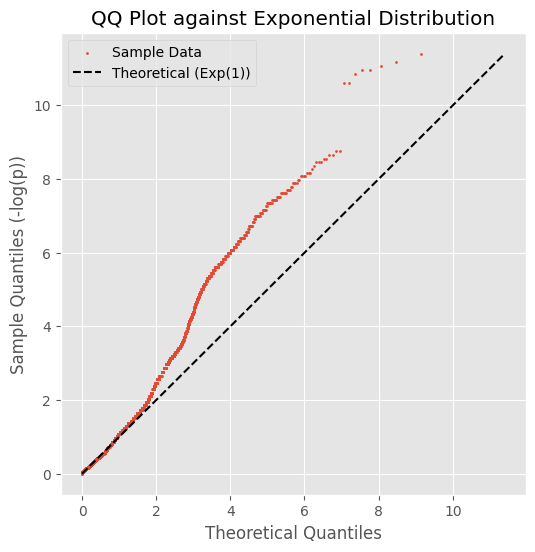

In [5]:
# check the fit of the sample -log(df['p_value']) to the exponential distribution using a QQ plot

plt.figure(figsize=(6, 6))

n = len(df_pvals)
sample_quantiles = np.sort(-np.log(df_pvals['p_value']))
# Generate theoretical quantiles for standard exponential distribution
theoretical_quantiles = -np.log(1 - (np.arange(1, n + 1) / (n + 1)))

plt.scatter(theoretical_quantiles, sample_quantiles, s=2, label='Sample Data')

# Add the y=x reference line
max_val = max(theoretical_quantiles.max(), sample_quantiles.max())
plt.plot([0, max_val], [0, max_val], 'k--', label='Theoretical (Exp(1))')

plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles (-log(p))')
plt.title('QQ Plot against Exponential Distribution')
plt.legend()
plt.show()

In [ ]:
def fit_empirical_null(data, bins=100, poly_deg=4, lower_range=0.25, upper_range=0.75, ax=None):
    """
    Fits an empirical null distribution using Efron's central matching method.
    Approximates the log-density with a polynomial and matches the curvature at the peak.

    Only fits the null distribution in the quantile range [lower_range, upper_range].
    """
    # 1. Compute histogram
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    lower_range_bin = np.quantile(data, lower_range)
    upper_range_bin = np.quantile(data, upper_range)
    
    fraction = np.mean((data >= lower_range_bin) & (data <= upper_range_bin))
    print(f"Range: [{lower_range_bin:.4f}, {upper_range_bin:.4f}]")
    print(f"Fraction of data in range: {fraction:.4f}")

    # 2. Fit polynomial to log-density (only where counts > 0 and in the quantile range [lower_range, upper_range])
    mask = (counts > 0) & (bin_centers >= lower_range_bin) & (bin_centers <= upper_range_bin)
    x = bin_centers[mask]
    y = np.log(counts[mask])
    
    # Fit polynomial of given degree to the log-counts
    coeffs = np.polyfit(x, y, poly_deg)
    poly = np.poly1d(coeffs)
    
    # 3. Find the peak (mode) of the fitted polynomial
    # We look for the point where derivative is 0
    deriv = poly.deriv()
    roots = deriv.roots
    
    # Filter for real roots within the data range
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[(real_roots >= x.min()) & (real_roots <= x.max())]
    
    if len(valid_roots) == 0:
        # Fallback: use the bin center with max count
        delta = x[np.argmax(y)]
    else:
        # Choose the root that gives the maximum log-density
        delta = valid_roots[np.argmax(poly(valid_roots))]
    
    # 4. Calculate sigma from curvature at the peak
    # Taylor expansion of log(f) around peak: log(f) ~ const - (z - delta)^2 / (2*sigma^2)
    # So, 2nd derivative = -1/sigma^2  =>  sigma = sqrt(-1 / 2nd_deriv)
    d2 = poly.deriv(2)(delta)
    
    if d2 >= 0:
        print("Warning: Fitted curve is convex at peak. Falling back to sample std.")
        sigma = np.std(data)
    else:
        sigma = np.sqrt(-1 / d2)
        
    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Histogram with dashed lines for boundaries
    ax.hist(data, bins=bins, density=True, alpha=0.5, color='gray', label='Histogram', edgecolor='black', linestyle='--')
    
    # Shade the region corresponding to 'mask' (bins used in the fit)
    bin_width = bin_edges[1] - bin_edges[0]
    ax.bar(bin_centers[mask], counts[mask], width=bin_width, color='green', alpha=0.3, label='Used in Fit', align='center')

    # plot bin centers
    ax.scatter(bin_centers, counts, color='red', s=10, label='Bin Centers')

    # plot the fitted polynomial
    x_grid_poly = np.linspace(lower_range_bin, upper_range_bin, 200)
    ax.plot(x_grid_poly, np.exp(poly(x_grid_poly)), 'b-', label=f'Poly Fit (deg={poly_deg})')
    
    x_grid = np.linspace(data.min(), data.max(), 200)
    null_pdf = stats.norm.pdf(x_grid, loc=delta, scale=sigma)
    ax.plot(x_grid, null_pdf, 'r--', linewidth=2, label=f'Empirical Null\n$\delta={delta:.3f}, \sigma={sigma:.3f}$')
    
    ax.set_title(f"Empirical Null Fit (Central Matching)")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()
    
    return delta, sigma

# Run the fit

block_nums = np.random.choice(np.arange(1, 128), size=10, replace=False)

for i in block_nums:
    print(f"Block: logit_{i}" )
    logits = df[f"logit_{i}"]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Empirical Null Fit
    delta, sigma = fit_empirical_null(logits, lower_range=0.05, upper_range=0.95, ax=axes[0])
    
    # Right: QQ Plot of -log(P-values)
    # Calculate P-values under the fitted null N(delta, sigma^2)
    # Two-sided p-value: 2 * (1 - CDF(|z|)) where z = (x - delta) / sigma
    z_scores = (logits - delta) / sigma
    p_values = 2 * stats.norm.sf(np.abs(z_scores))
    p_values = np.maximum(p_values, 1e-300) # avoid log(0)
    
    neg_log_pvals = -np.log(p_values)
    
    # Sort
    sorted_indices = np.argsort(neg_log_pvals)
    sample_quantiles = neg_log_pvals[sorted_indices]
    
    # Theoretical quantiles for Exp(1)
    n = len(logits)
    theoretical_quantiles = -np.log(1 - (np.arange(1, n + 1) / (n + 1)))
    
    # Determine points in range
    lower_cutoff = np.quantile(logits, 0.05)
    upper_cutoff = np.quantile(logits, 0.95)
    
    # We need to find which sorted quantiles correspond to logits in the range
    sorted_logits = logits.iloc[sorted_indices] if hasattr(logits, 'iloc') else logits[sorted_indices]
    in_range_mask = (sorted_logits >= lower_cutoff) & (sorted_logits <= upper_cutoff)
    
    # Plot
    axes[1].scatter(theoretical_quantiles[~in_range_mask], sample_quantiles[~in_range_mask], 
                    s=5, c='gray', alpha=0.5, label='Out of Range')
    axes[1].scatter(theoretical_quantiles[in_range_mask], sample_quantiles[in_range_mask], 
                    s=5, c='blue', alpha=0.5, label='In Range')
    
    # y=x line
    max_val = max(theoretical_quantiles.max(), sample_quantiles.max())
    axes[1].plot([0, max_val], [0, max_val], 'k--', label='Exp(1)')
    
    axes[1].set_xlabel('Theoretical Quantiles (Exp(1))')
    axes[1].set_ylabel('Sample Quantiles (-log(P))')
    axes[1].set_title(f"QQ Plot of -log(P-values)")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    print(f"Estimated Null: Mean (delta) = {delta:.4f}, Std (sigma) = {sigma:.4f}")